# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image = get_CIFAR10_data()
mean_img = mean_image
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.339707
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 

If we initialize our weights randomly, we will randomly guess the right class about 10% (0.1) of the time.  So if we have an average probability (random guesses' confidence) vector $[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]$, the average $L_i$ should be $-log(0.1)$.  Because $L_i = -ln($correct class' predicted softmax probability score$)$

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# I'm still confused as to what this "grad_check_sparse()" does /
#   whether it means my dW is correct.   -nxb; June 25, 2019   (Nathan X. Bendich)

numerical: -0.717180 analytic: 7.696033, relative error: 1.000000e+00
numerical: 0.255130 analytic: 3.425865, relative error: 8.613798e-01
numerical: 2.654877 analytic: -5.438695, relative error: 1.000000e+00
numerical: 2.982305 analytic: -0.097157, relative error: 1.000000e+00
numerical: -0.070524 analytic: 6.494513, relative error: 1.000000e+00
numerical: -2.335665 analytic: 4.560985, relative error: 1.000000e+00
numerical: 0.248565 analytic: -1.066731, relative error: 1.000000e+00
numerical: 1.229712 analytic: -8.157444, relative error: 1.000000e+00
numerical: 4.226113 analytic: 27.693812, relative error: 7.352053e-01
numerical: -1.912681 analytic: 1.954344, relative error: 1.000000e+00
numerical: 1.511959 analytic: 10.333051, relative error: 7.447096e-01
numerical: 1.484987 analytic: 1.559549, relative error: 2.449053e-02
numerical: -0.796746 analytic: 6.510481, relative error: 1.000000e+00
numerical: -1.938260 analytic: 3.186498, relative error: 1.000000e+00
numerical: -0.464112 a

Below cell is just debugging "softmax_loss_vectorized()" into existence

In [5]:
# TODO
# TODO:   vectorize
# TODO

# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.339707e+00 computed in 0.228253s
vectorized loss: 2.339707e+00 computed in 0.027705s
Loss difference: 0.000000
Gradient difference: 1625.623352


In [6]:
# In this cell, I'm debugging the difference between
# 1. grad_naive   and
# 2. grad_vectorized (1 for loop;   not fully vectorized)
print("grad_naive[0]: ", grad_naive[0])
print("grad_naive[0].shape: ", grad_naive[0].shape)
print('\n'*3)
'''
grad_naive[0]:  [-0.031055   -0.16376322  0.23089359 -0.02020012  0.26430801  0.35457691
  0.25983297 -0.17145018 -0.42242013 -0.30072284]
grad_naive[0].shape:  (10,)
'''

print("grad_vectorized[0]: ", grad_vectorized[0])
print("grad_vectorized[0].shape: ", grad_vectorized[0].shape)
'''
grad_vectorized[0]:  [-0.02437726 -0.0482656   0.20306596 -0.02521198  0.34862779  0.30397925
  0.12904819 -0.11513386 -0.4445086  -0.41233222]
grad_vectorized[0].shape:  (10,)
'''


print(grad_naive[0] - grad_vectorized[0])
'''
[-0.00667773 -0.11549762  0.02782764  0.00501186 -0.08431978  0.05059766
  0.13078478 -0.05631632  0.02208847  0.11160938]
'''

grad_naive[0]:  [  3.6279844   22.67234006 -14.41120231  -8.62455098  18.40179519
   0.86551009  -5.83533509  -6.12431737   3.69177343 -12.6589844 ]
grad_naive[0].shape:  (10,)




grad_vectorized[0]:  [ 3.64002078  1.27426378 -3.47067157 -2.33908268 -0.23407856 -1.420184
 -1.88633755 -0.29999132  1.44771757  3.5486072 ]
grad_vectorized[0].shape:  (10,)
[-1.20363842e-02  2.13980763e+01 -1.09405307e+01 -6.28546830e+00
  1.86358737e+01  2.28569409e+00 -3.94899753e+00 -5.82432605e+00
  2.24405585e+00 -1.62075916e+01]


'\n[-0.00667773 -0.11549762  0.02782764  0.00501186 -0.08431978  0.05059766\n  0.13078478 -0.05631632  0.02208847  0.11160938]\n'

In [7]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 384.997212


/home/cat_macys_vr/assignment1/cs231n/classifiers/softmax.py:228: RuntimeWarning: overflow encountered in square
  denoms = np.square(dW_term_3_3)
/home/cat_macys_vr/assignment1/cs231n/classifiers/softmax.py:171: RuntimeWarning: invalid value encountered in true_divide
  probabilities= (unnormalized_probs.T /np.sum(unnormalized_probs, axis=ACROSS)).T
/home/cat_macys_vr/assignment1/cs231n/classifiers/softmax.py:182: RuntimeWarning: divide by zero encountered in log
  tot_loss = np.sum(-np.log(correct_probs))
/usr/local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cat_macys_vr/assignment1/cs231n/classifiers/softmax.py:293: RuntimeWarning: overflow encountered in multiply
  numer8r_plus = (dW_term_3_2_j * dW_term_3_4[which_imgs_r_labeled_j]).T


iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
That took 18.289903s


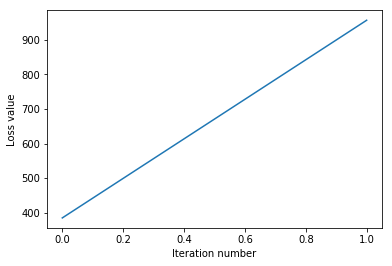

In [8]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [9]:
# Data:  It used to give us a 0.03 accuracy; now it gives us 0.23
#   "No! It doesn't work! Aaaaaargh. The gradient is probably wrong.  -nxb, June 25, 2019"
#   -when the gradient dW calculation was backwards

# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.100265
validation accuracy: 0.087000


In [10]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.103000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        _ = 
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

SyntaxError: invalid syntax (<ipython-input-11-4800c9e9b748>, line 23)

In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

NameError: name 'best_softmax' is not defined

**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

NameError: name 'best_softmax' is not defined

In [14]:
# Just debugging
print(X_dev.shape)
print(W.shape)
print((X_dev.dot(W)).shape)

(500, 3073)
(3073, 10)
(500, 10)


In [15]:
# debugging 3_1 term in "vectorized"

print("len(dW_3_1s_naive): ", len(dW_3_1s_naive)) # len(3_1s) == 500
print("dW_3_1s_naive[0].shape: ", dW_3_1s_naive[0].shape) # dW_3_1s_naive[0].shape == (3073,)
print("dW_3_1s_vectorized[0].shape: ", dW_3_1s_vectorized[0].shape) # (43,3073)
print("0th image's label", y_dev[0]) # 1 (0-indexed)
#print("dW_3_1s_naive[0]: ", dW_3_1s_naive[0]) # shape == (3073,)
print("dW_3_1s_naive[0]: ", dW_3_1s_naive[0])
print("dW_3_1s_vectorized[1]: ", dW_3_1s_vectorized[1])

NameError: name 'dW_3_1s_naive' is not defined

In [16]:
#   REPL development of "softmax_loss_vectorized":
# Debugging "def softmax_loss_vectorized()"   into existence:

X=X_dev
y=y_dev
reg=5e1

loss = 0.0
dW = np.zeros_like(W) # same as np.zeros(W.shape) 
# -nxb (Nathan X. Bendich) (Mon Jun 24 13:56:08 EDT 2019)

#############################################################################
# TODO: Compute the softmax loss and its gradient using no explicit loops.  # 
# Store the loss in loss and the gradient in dW. If you are not careful     # 
# here, it is easy to run into numeric instability. Don't forget the        # 
# regularization!                                                           # 
#############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_train   = n_train   = X.shape[0]
num_classes = n_classes = dW.shape[1]
num_pix_vals= n_pix_vals= X.shape[1]

# Implementation NOTES:
# I just went straight to implementing the loss_i as a vectorized calculation.  It's faster this way, and it's easy enough with SVM loss and grad dW as a template.
# -nxb (Nathan X. Bendich) (Mon Jun 24 13:56:08 EDT 2019)

# Vectorized version of "scores = X[i].dot(W)" from "...naive()"
SVM_scores=X.dot(W)         #(X.T).dot(W) # scores.shape==(N_train, 10)    ie. (500,10), for X_dev

# unnormalized_probs.shape == (500,10)  (500==num_train)
unnormalized_probs=np.exp(SVM_scores) # I also considered calling this variable "exps." 
# -nxb (Nathan X. Bendich) (Mon Jun 24 13:56:08 EDT 2019)

ACROSS=1
# This variable "probabilities" could also called "softmax_scores"  or "softmax_outputs"
probabilities= (unnormalized_probs.T /np.sum(unnormalized_probs, axis=ACROSS)).T    
# probabilities.shape == (num_train, 10)    (500, 10) for X_dev

# All comments/code written by NXB (Nathan X. Bendich)  on Monday, Jun 24 13:56:08 EDT 2019
correct_probs=probabilities[range(num_train), y]
# correct_probs.shape == (num_train, 10)

###################################################################################################
# Calculate loss:
###################################################################################################
# Sum over training images:
tot_loss = np.sum(-np.log(correct_probs))
# Average loss per training image
loss = (tot_loss / num_train)
# Regularize
loss += np.sum(0.5*reg*W*W)

DOWN=0
ACROSS=1
import math
dW_term_3_3 =np.sum(unnormalized_probs,axis=ACROSS)# 3_3.shape== (500,)
dW_term_3_4 =unnormalized_probs[range(n_train), y] # rename "dW_term_3_4" to "corrects_confidences"

#dW_term_3_2  = X[i] * (math.e ** (W[:,j].dot(X[i])))

# TODO FIXME FIXME
# TODO FIXME FIXME:  double-check whether the calculation for "dW_term_3_2" is this simple
# TODO FIXME FIXME
dW_term_3_2 = (X.T).dot(  unnormalized_probs)  #does this work?   #  unnormed[i,j]
# TODO FIXME FIXME
# TODO FIXME FIXME

#
# dW_term_3_2.shape == (3072, 10) == (n_pix_vals, n_classes)
# Maybe this kind of solution is too "moonshot"-ish (for "no_loops" (fully vectorized); not "one_loop" like we're doing right now)
#

# Below was just for rubber ducky debugging.  It turns out that:
# np.isclose(
#   e** (X[i].dot(W[:,j]) ),
#   unnormed[i,j])
'''
leave_i=False
for i in range(n_train):
    if leave_i:
        break
    for j in range(n_classes):
        if not np.isclose(
            unnormalized_probs[i,j],
            math.e**(X[i].dot(W[:,j])),
        ):
            print('STAHP!\n'*99)
            print("unnormalized_probs[i,j]:", unnormalized_probs[i,j]),
            print("math.e**(X[i].dot(W[:,j]) ):", math.e**(X[i].dot(W[:,j])) ),
            print()
            print()
            leave_i=True
            break
if leave_i:
    return
'''

for j in range(n_classes):
    which_imgs_r_labeled_j = np.nonzero(y==j)[0] # (45,)
    num_labeled_j = n_labeled_j= which_imgs_r_labeled_j.shape[0] # 45
    imgs_labeled_j = X[which_imgs_r_labeled_j,:] # (45, 3073)
    intermedi8_term_3_1= W[:,j].dot((imgs_labeled_j.T)) # collection of scalars (multiplicative factors)
    #print("intermedi8_term_3_1.shape: ", intermedi8_term_3_1.shape)  # (45,)
    scalings_3_1=\
        np.repeat(
            intermedi8_term_3_1.reshape(n_labeled_j, 1),
            n_pix_vals,
            axis=ACROSS) # (45, 3073)
    dW_term_3_1 = imgs_labeled_j *  scalings_3_1
    #print("dW_term_3_1.shape: ", dW_term_3_1.shape) # (45, 3073)
    dW_term_3_3_j = dW_term_3_3[which_imgs_r_labeled_j] # 3_3[indices];
    #dW_term_3_3_j.shape == (45,)
    dW_term_3_3_j = np.repeat(
        dW_term_3_3_j.reshape(dW_term_3_3_j.shape[0],   1),
        n_pix_vals,
        axis=ACROSS) # (45, 3073)
    numer8r_minus=   (dW_term_3_1 * dW_term_3_3_j) # shape==(45, 3073)      NOTE: minus is in the numer8r = plus - minus line, not this line. -nxb; June 26, 2019
    # TODO FIXME FIXME
    # TODO FIXME FIXME
    # TODO FIXME FIXME     the denom.
    # TODO FIXME FIXME     the numer8r_plus.
    # TODO FIXME FIXME     is the usage of "np.sum(...)" in "numer8r_plus" correct?
    # TODO FIXME FIXME
    # TODO FIXME FIXME
    denom = np.random.random(numer8r_minus.shape) # TODO FIXME FIXME
    numer8r_plus = dW_term_3_2[:,j] * np.sum(dW_term_3_4[which_imgs_r_labeled_j]) # in this expression, 2nd_term.shape == (45,)

    #numer8r_plus = np.random.random(numer8r_minus.shape)
    # TODO FIXME FIXME
    # TODO FIXME FIXME
    numer8r = numer8r_plus - numer8r_minus # numer8r.shape == (45, 3073)
    delta_W_j = np.sum((numer8r / denom), axis=DOWN)
    #print("delta_W_j.shape: ", delta_W_j.shape)
    dW[:,j] += delta_W_j
    # denom.shape == (45,)

print("unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]]\n: ",
      (unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]]))
print("unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]].shape: ",
      (unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]]) .shape)

unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]]
:  [1.12223939 1.00806749 1.079321   1.15469002 0.8366388  0.80148846
 0.83190907 0.8130907  1.93166896 1.07836067 0.88952797 1.02520632
 0.5410451  0.71406276 1.25921438 1.81053392 0.57230671 0.74782942
 1.19000536 1.52705526 1.34340852 0.78385716 0.50596835 0.84525665
 0.86795944 1.32641033 1.30775656 1.20028632 1.98089364 0.98175975
 1.08176248 1.9918017  1.17548053 1.07183075 1.12210476 0.47796586
 0.73893718 0.73591958 1.14877835 1.3796181  1.2629283  0.89378733
 1.16306795 1.09885945 0.78918732 1.16778044 0.74326238 1.1901531
 1.27036667 0.78729754 1.50489656 1.28691023 0.76272124 1.08278966
 1.20303933 1.43709917 0.60215556 0.61385687 1.41912312 1.50487661
 1.90263317]
unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]].shape:  (61,)


In [17]:
#def softmax_loss_vectorized(W, X, y, reg):
"""
Softmax loss function, vectorized version.

Inputs and outputs are the same as softmax_loss_naive.
"""

# Initialize the loss and gradient to zero.
loss = 0.0
dW = np.zeros_like(W) # same as np.zeros(W.shape) 
# -nxb (Nathan X. Bendich) (Mon Jun 24 13:56:08 EDT 2019)

#############################################################################
# TODO: Compute the softmax loss and its gradient using no explicit loops.  #
# Store the loss in loss and the gradient in dW. If you are not careful     #
# here, it is easy to run into numeric instability. Don't forget the        #
# regularization!                                                           #
#############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_train   = n_train   = X.shape[0]
num_classes = n_classes = dW.shape[1]
num_pix_vals= n_pix_vals= X.shape[1]

# Implementation NOTES:
# I just went straight to implementing the loss_i as a vectorized calculation.  It's faster this way, and it's easy enough with SVM loss and grad dW as a template.
# -nxb (Nathan X. Bendich) (Mon Jun 24 13:56:08 EDT 2019)

# Vectorized version of "scores = X[i].dot(W)" from "...naive()"
SVM_scores=X.dot(W)         #(X.T).dot(W) # scores.shape==(N_train, 10)    ie. (500,10), for X_dev

# unnormalized_probs.shape == (500,10)  (500==num_train)
unnormalized_probs=np.exp(SVM_scores) # I also considered calling this variable "exps." 
# -nxb (Nathan X. Bendich) (Mon Jun 24 13:56:08 EDT 2019)

ACROSS=1
# This variable "probabilities" could also called "softmax_scores"  or "softmax_outputs"
probabilities= (unnormalized_probs.T /np.sum(unnormalized_probs, axis=ACROSS)).T  
# probabilities.shape == (num_train, 10)    (500, 10) for X_dev

# All comments/code written by NXB (Nathan X. Bendich)  on Monday, Jun 24 13:56:08 EDT 2019
correct_probs=probabilities[range(num_train), y]
# correct_probs.shape == (num_train, 10)

###################################################################################################
# Calculate loss:
###################################################################################################
# Sum over training images:
tot_loss = np.sum(-np.log(correct_probs))
# Average loss per training image
loss = (tot_loss / num_train)
# Regularize
loss += np.sum(0.5*reg*W*W)

###################################################################################################
# Calculate grads (dW):
###################################################################################################
    ###################################################################################################
    # TODO: rename all the mysterious, cryptic abstract variables so you can better wrap your head around everything
    #  especially if you come back to it in about ~1 month.    -nxb ("Nathan X. Bendich") (Tue Jun 25 20:13:58 EDT 2019)
    ###################################################################################################
    # TODO FIXME FIXME   rename variables
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    #
    # Debugging:
    #   3_1 is fine
    #
    #   3_3 fine
    #   3_4 fine
    #
    #
    #
    #
    #
    #
    #
    #
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
    ###################################################################################################
DOWN=0
ACROSS=1
import math

###################################################################################################
# Calculate terms 3_3 and 3_4 (vectorized):
###################################################################################################
dW_term_3_3 =np.sum(unnormalized_probs,axis=ACROSS)     # 3_3.shape== (500,)
denoms = np.square(dW_term_3_3)
dW_term_3_4 =unnormalized_probs[range(n_train), y] # rename "dW_term_3_4" to "corrects_confidences"
# Terms 3_3 and 3_4 are correct        -nxb debugging vectorized() to match it up with (Thu Jun 27 11:12:18 EDT 2019)
  # Now we just have to use these 2 terms (3_3 and 3_4)   PROPERLY in the our later calculation.

#dW_term_3_2  = X[i] * (math.e ** (W[:,j].dot(X[i])))
# TODO FIXME FIXME
# TODO FIXME FIXME:  double-check whether the calculation for "dW_term_3_2" is this simple    (below)
# TODO FIXME FIXME
#dW_term_3_2 = (X.T).dot(  unnormalized_probs)  #does this work?   #  unnormed[i,j]    I don't think so.
# dW_term_3_2.shape == (3072, 10) == (n_pix_vals, n_classes)
# Maybe this kind of solution is too "moonshot"-ish (for "no_loops" (fully vectorized); not "one_loop" like we're doing right now)
#
#   DONE:  this (vectorized) 3_1 term is the same as the 3_1 term in "naive."

###################################################################################################
for j in range(n_classes):
    ###################################################################################################
    #       Calculate "term_3_1" :
    ###################################################################################################
    which_imgs_r_labeled_j = np.nonzero(y==j)[0] # (45,)      # rename to "which_imgs_r_labeled_j"?
    num_labeled_j = n_labeled_j= which_imgs_r_labeled_j.shape[0] # 45
    imgs_labeled_j = X[which_imgs_r_labeled_j,:] # (45, 3073)
    intermedi8_term_3_1= np.exp   (W[:,j].dot((imgs_labeled_j.T))) # collection of scalars (multiplicative factors)    
    #(45,)  == intermedi8_term_3_1.shape
    scalings_3_1=\
        np.repeat(
            intermedi8_term_3_1.reshape(n_labeled_j, 1),
            n_pix_vals,
            axis=ACROSS) # (45, 3073)

    dW_term_3_1 = imgs_labeled_j *  scalings_3_1    
    # (45, 3073) == dW_term_3_1.shape
    #This 3_1_term was checked against "naive"s 3_1_term.  To great success.!

    ###################################################################################################
    #       Calculate "term_3_3" :
    ###################################################################################################
    dW_term_3_3_j = dW_term_3_3[which_imgs_r_labeled_j] # 3_3[indices];
    #dW_term_3_3_j.shape == (45,)
    dW_term_3_3_j = np.repeat(
        dW_term_3_3_j.reshape(dW_term_3_3_j.shape[0],   1),
        n_pix_vals,
        axis=ACROSS) # (45, 3073)

    ###################################################################################################
    #       Calculate "term_3_1 * term_3_3" :
    ###################################################################################################
    numer8r_minus=   (dW_term_3_1 * dW_term_3_3_j)
    # (45, 3073) == numer8r_minus.shape      NOTE: minus is in the numer8r = plus - minus line, not this line. -nxb; June 26, 2019
    # TODO FIXME FIXME
    # TODO FIXME FIXME     the denom.
    # TODO FIXME FIXME     the numer8r_plus.
    # TODO FIXME FIXME     is the usage of "np.sum(...)" in "numer8r_plus" correct?
    # TODO FIXME FIXME

    ############################################################################################################
    ###################################################################################################
    #       Calculate "term_3_2" :
    ###################################################################################################
    dW_term_3_2_j = (imgs_labeled_j.T) *  unnormalized_probs[which_imgs_r_labeled_j, [j for k in range(n_labeled_j)]]
    # (3073, 61) == dW_term_3_2_j.shape
    ###################################################################################################
    #       Calculate "term_3_2 * term_3_4" :
    ###################################################################################################
    numer8r_plus = (dW_term_3_2_j * dW_term_3_4[which_imgs_r_labeled_j]).T
    # (61, 3073) == numer8r_plus.shape
    # The old way I was trying to calculate this sub-term:   numer8r_plus = dW_term_3_2_j[:,j] * np.sum(dW_term_3_4[which_imgs_r_labeled_j]) # in this expression, 2nd_term.shape == (45,)

    ############################################################################################################
    ###################################################################################################
    #       Calculate dW
    ###################################################################################################
    dW[:,j]+=np.sum(dW_term_3_2_j, axis=ACROSS) # term_3_2

    #######################################
    # TODO: uncomment the below quoted-out lines (''' ... ''')
    #######################################
    '''
    dW[:,j]+= np.sum(
      ((numer8r_plus - numer8r_minus).T
       / denoms[which_imgs_r_labeled_j] ),
      axis= ACROSS)
    '''
    ############################################################################################################

#######################################
# Right now the gradient is a sum over all training examples, but we want it
# to be an average instead. so we divide by num_train.
dW  /=  n_train
#######################################

#######################################
# Partial derivative of d(reg_term) / dW   == lambda*W
# It's easier to see if we do it elementwise; the regularization term   is 0.5*reg*(element**2).  
#   So    d(term) / d(element)  == reg*element
dW += reg*W
#######################################

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [18]:
#debugging 3_2 term in "vectorized()"

#unnormalized_probs # shape == (500,10)
print("which_imgs_r_labeled_j.shape: ", which_imgs_r_labeled_j.shape)
print("unnormalized_probs[which_imgs_r_labeled_j].shape: ", unnormalized_probs[which_imgs_r_labeled_j].shape)
# (54, 10) == above_term.shape
print("unnormalized_probs[which_imgs_r_labeled_j, 0].shape: ", unnormalized_probs[which_imgs_r_labeled_j, 0].shape)
# (54,) == above_term.shape

which_imgs_r_labeled_j.shape:  (61,)
unnormalized_probs[which_imgs_r_labeled_j].shape:  (61, 10)
unnormalized_probs[which_imgs_r_labeled_j, 0].shape:  (61,)


In [19]:
imgs_labeled_j.shape

(61, 3073)

In [23]:
img_0 = imgs_labeled_j[0][:-1].reshape(32,32,3)
offset=mean_image.reshape(32,32,3)
img_0 = (img_0+offset)/255
plt.imshow(img_0)
plt.show()

In [22]:
print("np.amax(imgs_labeled_j): ", np.amax(imgs_labeled_j))
print("np.amin(imgs_labeled_j): ", np.amin(imgs_labeled_j))

np.amax(imgs_labeled_j):  154.22104081632654
np.amin(imgs_labeled_j):  -134.65504081632653
